In [0]:
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

{}

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d splcher/animefacedataset

animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import os
from glob import glob

W = './weights/'


if not(os.path.exists(W)):
  os.makedirs(os.path.join(W,"VAE"))
  print('[INFO] Add folder VAE')


In [0]:
#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('animefacedataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
import numpy as np

def create_vae_encoder(input_dim,output_dim,conv_filters,conv_kernel_sz,convStrd,use_batch_norm = False,use_dropout=False):
    global K
    K.clear_session()
    
    n_conv = len(conv_filters)
    
    encoder_input = Input(input_dim, name='encoder_input')
    x = encoder_input
    
    for i in range(n_conv):
        x = Conv2D(filters=conv_filters[i],kernel_size=conv_kernel_sz[i],strides=convStrd[i],padding="same",name="encoded_conv_"
                  +str(i+1))(x)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        
        x = LeakyReLU()(x)
        
        if use_dropout:
            x = Dropout(0.25)(x)
        
    shape_before_flatten = K.int_shape(x)[1:]
    x =  Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flatten, Model(encoder_input, encoder_output)

Using TensorFlow backend.


In [0]:
INPUT_DIM = (128,128,3)
Z_DIM = 200
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = create_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64],
                                    conv_kernel_sz = [3,3],
                                    convStrd = [4,4])

vae_encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoded_conv_1 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 32)   0           encoded_conv_1[0][0]             
__________________________________________________________________________________________________
encoded_conv_2 (Conv2D)         (None, 8, 8, 64)     18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
    n_layers = len(conv_filters)

  # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
    if i < n_layers - 1:
        x = LeakyReLU()(x)
    else:
        x = Activation('sigmoid')(x)

  # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [0]:
decoder_input, decoder_output, vae_decoder = build_decoder(Z_DIM, vae_shape_before_flattening, 
                                                           conv_filters = [64, 64, 32, 3],
                                                            conv_kernel_size = [3,3,3,3],
                                                          conv_strides = [2,2,2,2])
vae_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 64, 64, 32)        18464     
_________________________________________________________________
decoder_conv_3 (Conv2DTransp (None, 128, 128, 3)       867 

In [0]:
vae_input = vae_encoder_input

vae_output = vae_decoder(vae_encoder_output)

vae_model = Model(vae_input,vae_output)

vae_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoded_conv_1 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 32)   0           encoded_conv_1[0][0]             
__________________________________________________________________________________________________
encoded_conv_2 (Conv2D)         (None, 8, 8, 64)     18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
# dataset 
import glob
import os
DATA_FOLDER = os.path.join(os.getcwd(),'data')
filenames = np.array(glob.glob(os.path.join(DATA_FOLDER,'images' ,'*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
dataflow = ImageDataGenerator(rescale=1/255.0).flow_from_directory(DATA_FOLDER,
                                                                   target_size=INPUT_DIM[:2],
                                                                  batch_size = 200,shuffle=True,
                                                                  class_mode = 'input',subset='training')

Total number of images : 63565
Found 63565 images belonging to 1 classes.


In [0]:
LOSS_FACTOR = 10000
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

checkpoint = ModelCheckpoint(os.path.join(os.getcwd(),'weights', 'VAE/weights.h5'), save_weights_only = True, verbose=1)

adam_opt = Adam(lr=0.0005)
vae_model.compile(optimizer=adam_opt, loss=total_loss,metrics=[r_loss,kl_loss])


In [0]:
hhh = vae_model.fit_generator(dataflow,shuffle=True,epochs=50,initial_epoch=0,steps_per_epoch=NUM_IMAGES/200,callbacks=[checkpoint])

Epoch 1/50
318/317 [==============================] - 559s 2s/step - loss: 512.2024 - r_loss: 0.0479 - kl_loss: 33.0462

Epoch 00001: saving model to /content/weights/VAE/weights.h5
Epoch 2/50
318/317 [==============================] - 556s 2s/step - loss: 383.1946 - r_loss: 0.0336 - kl_loss: 47.1425

Epoch 00002: saving model to /content/weights/VAE/weights.h5
Epoch 3/50
318/317 [==============================] - 557s 2s/step - loss: 355.4246 - r_loss: 0.0306 - kl_loss: 49.0805

Epoch 00003: saving model to /content/weights/VAE/weights.h5
Epoch 4/50
318/317 [==============================] - 555s 2s/step - loss: 345.1179 - r_loss: 0.0294 - kl_loss: 51.0398

Epoch 00004: saving model to /content/weights/VAE/weights.h5
Epoch 5/50
318/317 [==============================] - 560s 2s/step - loss: 339.9093 - r_loss: 0.0287 - kl_loss: 52.4605

Epoch 00005: saving model to /content/weights/VAE/weights.h5
Epoch 6/50
318/317 [==============================] - 557s 2s/step - loss: 334.7649 - r_lo

In [0]:
def plot_compare(images=None, add_noise=False):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.3, wspace=0.3)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img) 

In [0]:
example_batch = next(dataflow)
print(len(dataflow))
example_batch = example_batch[0]
example_images = example_batch[:10]
example_images.shape

318


(10, 128, 128, 3)

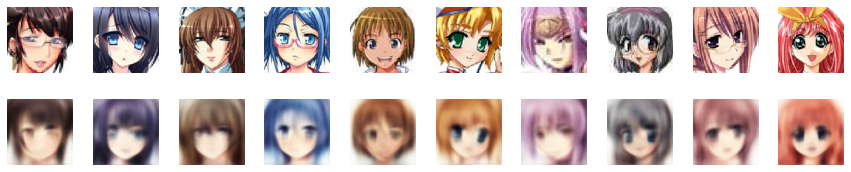

In [0]:
import matplotlib.pyplot as plt
plot_compare(example_images)

In [0]:
import cv2
bm_im = cv2.imread('images.png')
bm_im = cv2.resize(bm_im, (128,128))
bm_im = bm_im/255.0
bm_im = np.expand_dims(bm_im, axis=0)
plot_compare(bm_im)

error: ignored

In [0]:
vae_model.save('vae1.h5')

In [0]:
from keras.models import load_model
model2 = load_model('vae1.h5')